In [11]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Network

## Template 03
## FIFA dataset 


In [12]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib

from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score  # Import function to calculate various metric

from collections.abc import Callable  # Type hinting callable objects/functions
from typing import Literal  # Literal type hints to restrict variable values

from sklearn.preprocessing import StandardScaler  # Import for standardizing features (zero mean, unit variance)
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
#from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix # Custom utility

In [13]:
def fn_plot_torch_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()




In [14]:
print (fn_plot_torch_hist.__doc__)


Args:
    hist_df: a dataframe with following ccolumns
        column 0: accuracy
        column 1: loss
        column 2: val_accuracy
        column 3: val_loss
        While plotting columns are accessed by index
        so that even if the column names are different it will not throw exceptions.



In [15]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [16]:
print (fn_plot_confusion_matrix.__doc__)


Args:
    y_true: Ground Truth
    y_pred : Predictions
    labels : labels in a dictonary
              {0: 'Goal Keeper',
              1: 'Defender',
              2: 'Mid-Fielder',
              3: 'Forward'}




In [17]:
###----------------------
### Some basic parameters
###----------------------

inpDir = Path('..') / '..' / 'input'
outDir = Path('..') / 'output'
modelDir = Path('..') / 'models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 100 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2
TRAIN_SIZE=454 * BATCH_SIZE
# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [18]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Basic Hygiene

In [19]:
# Check if all directories are present
outDir.mkdir(parents=True, exist_ok=True)

modelSubDir = modelDir/ subDir
modelSubDir.mkdir(parents=True, exist_ok=True)

## Read FIFA 2019 data set

In [20]:
data_df = pd.read_csv('fifa_2019.csv')
data_df.shape

(18207, 89)

In [21]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [22]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [23]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [24]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [25]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [26]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [27]:
# splitting in train ans test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
train_df.shape, test_df.shape

((14517, 34), (3630, 34))

In [28]:
# important to reset the indies as we will be fetching by index

train_df = train_df.reset_index(drop=True)
display (train_df.head())

test_df = test_df.reset_index(drop=True)
display(test_df.head())

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,62.0,57.0,51.0,47.0,61.0,42.0,27.0,41.0,59.0,...,63.0,52.0,21.0,16.0,12.0,11.0,7.0,10.0,12.0,11.0
1,3,55.0,42.0,58.0,60.0,62.0,61.0,56.0,52.0,60.0,...,60.0,53.0,29.0,25.0,22.0,7.0,12.0,6.0,9.0,10.0
2,2,56.0,36.0,61.0,51.0,69.0,60.0,52.0,57.0,66.0,...,54.0,50.0,23.0,22.0,27.0,12.0,10.0,9.0,9.0,14.0
3,0,11.0,12.0,35.0,12.0,12.0,22.0,13.0,40.0,20.0,...,20.0,60.0,11.0,10.0,15.0,69.0,70.0,66.0,67.0,73.0
4,2,66.0,44.0,66.0,48.0,70.0,74.0,75.0,62.0,67.0,...,76.0,60.0,40.0,38.0,28.0,14.0,12.0,6.0,12.0,12.0


,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,2,66.0,33.0,72.0,55.0,81.0,69.0,65.0,61.0,79.0,...,57.0,68.0,23.0,26.0,30.0,12.0,14.0,16.0,6.0,10.0
1,2,71.0,43.0,68.0,43.0,72.0,74.0,69.0,70.0,78.0,...,64.0,66.0,39.0,26.0,16.0,14.0,14.0,13.0,6.0,8.0
2,2,67.0,43.0,61.0,49.0,65.0,48.0,35.0,44.0,65.0,...,54.0,47.0,49.0,13.0,19.0,9.0,12.0,15.0,12.0,13.0
3,2,55.0,37.0,69.0,45.0,67.0,50.0,51.0,64.0,62.0,...,53.0,61.0,55.0,61.0,57.0,13.0,7.0,10.0,8.0,12.0
4,1,25.0,82.0,61.0,20.0,51.0,25.0,33.0,63.0,60.0,...,42.0,67.0,77.0,78.0,70.0,15.0,12.0,13.0,14.0,15.0


In [29]:
list(labels.keys())

[0, 1, 2, 3]

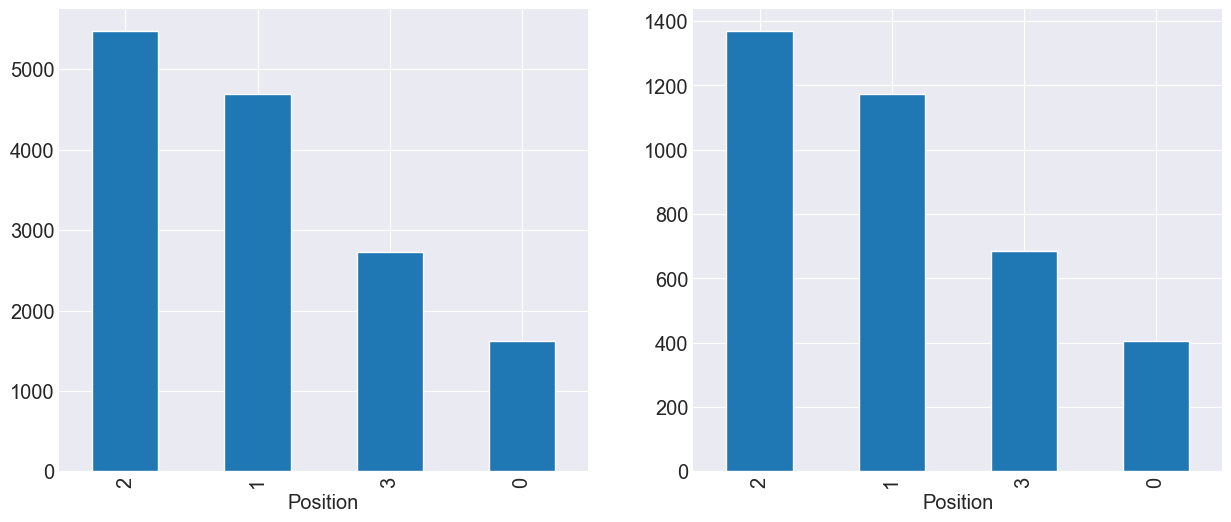

In [30]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
train_df['Position'].value_counts().plot(kind = "bar", ax = ax);

ax = axes[1]
test_df['Position'].value_counts().plot(kind = "bar", ax = ax);

In [31]:
class_labels={0:'Goal Keeper', 1:'Defender', 2:'Mid-Fielder', 3:'Forward'}
labels=data_df['Position']
features_df=data_df.drop('Position',axis=1)
features_df.shape,labels.shape

((18147, 33), (18147,))

In [32]:
# splitting in train ans test datasets
train_df, test_df = train_test_split(data_df,
                                     stratify=data_df['Position'],
                                     train_size=TRAIN_SIZE,
                                     #test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE )
train_df.shape, test_df.shape


((14528, 34), (3619, 34))

Custom Dataset

In [35]:
class GlobalScalar:
    _instance=None

    def __init__(self):
        if GlobalScalar._instance is not None:
            raise Exception('GlobalScalar is Singleton Class')
        self.scaler = StandardScaler()

    @classmethod
    def get_instance(cls):
        if cls._instance is None:
            cls._instance=GlobalScalar()
        return cls._instance

In [37]:
class FifaDS(Dataset):
    globalScaler=GlobalScalar.get_instance()#protected variable

    def __init__(self,dataframe, device=device,is_train=True,label_col=None):
        self.df=dataframe
        self.device=device
        self.is_train=is_train
        self.label_col=label_col
        self.scaler=self.globalScaler.scaler

        self.labels=self.df[label_col].to_numpy()
        if self.is_train:
            X=self.df.drop(label_col,axis=1)
            self.features=self.scaler.fit_transform(X)
        else:
            X=self.df.drop(label_col,axis=1)
            self.features=self.scaler.transform(X)

        def __len__(self):
            return len(self.features)
        def __getitem__(self,index):
            feature=self.features[index]
            label=self.labels[index]
            return feature,label

In [ ]:
v# X_train = ss.fit_transform(X_train)
# X_test = ss.transform(X_test)

In [ ]:
# y_train=y_train.to_numpy()
# y_test=y_test.to_numpy()

In [ ]:
# type(X_train), type(X_test), type(y_train), type(y_test)